# Building Deep Learning Applications with Keras: Transfer learning

## Galaxy morphological classification

Another problem that can be solved with supervised learning is the one of *galaxy morphological classification*, i.e. the problem of dividing galaxies into groups based on their visual appearance.
We took some samples from the [EFIGI reference dataset](https://www.aanda.org/articles/aa/pdf/forth/aa16423-10.pdf). For simplicity's sake we will work with three classes of galaxis only:  **elliptical** (with no overly defined structure), **irregular** (resembling a blob of glowing dust) and **spiral** (resembling a pinwheel).

<table>
<tr>
<td>
<img align="middle"   width='200' heith='100' src='images/eliptical.png'>
<img align="middle"   width='200' heith='100' src='images/irregular.png'>
<img align="middle"   width='200' heith='100' src='images/sspiral.png'>
</td>
</tr>
</table>

## Using a pretrained model

This task is in the same category as the one of lane and road following, image classification. But there is a difference here. We have less data: there are only 300 images for training and 100 images for testing. One way to circunvent this issue is to use one technique called **transfer learning**.

One way to apply this technique is by first train a base network on a base dataset and then we "transfer" the learned features to a second network to be trained on the efige dataset.

Keras have some available pre-trained models on the [ImageNet dataset](http://www.image-net.org/):

 - [Xception](https://keras.io/applications/#xception)
 - [VGG16](https://keras.io/applications/#vgg16)
 - [VGG19](https://keras.io/applications/#vgg19)
 - [ResNet50](https://keras.io/applications/#resnet50)
 - [InceptionV3](https://keras.io/applications/#inceptionv3)
 - [InceptionResNetV2](https://keras.io/applications/#inceptionresnetv2)
 - [MobileNet](https://keras.io/applications/#mobilenet)
 - [DenseNet](https://keras.io/applications/#densenet)
 - [NASNet](https://keras.io/applications/#nasnet)


Here you will see how to use one of these models.

In [1]:
import numpy as np
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
import os
import subprocess
from plots import plot_confusion_matrix
from util import generator2array

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


If you want to download the data for yourself you can uncomment the cell below.

In [ ]:
# if not os.path.exists("efigi_data"):
#     pro = subprocess.Popen(["bash", "download_efigi.sh"])
#     pro.wait()

## ImageDataGenerator

We can use NumPy arrays as input to the `fit()` method. But it is way more efficient to use the [`ImageDataGenerator`](https://keras.io/preprocessing/image/) class. This class read images from a folder and generates batches of tensors with real-time data augmentation.

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        rotation_range=45,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory('/efigi_data/train',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 300 images belonging to 3 classes.


In [4]:
test_generator = test_datagen.flow_from_directory('/efigi_data/test',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 150 images belonging to 3 classes.


## Using a CNN

As a comparison, let's see how a CNN model perform when we trained it on this data.

Hyperparams:

height = 224
width = 224
channels = 3
architecture = [100, 3]
activations = ['relu', 'softmax']
conv_activations = ['relu', 'relu']
conv_architecture = [32, 64]
kernel_sizes = [5, 5]
pool_kernel = [2, 2]
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1

Keras model:


Training:

Epoch 1/3
10/10 [==============================] - 66s 7s/step - loss: 1.0811 - acc: 0.4371
Epoch 2/3
10/10 [==============================] - 63s 6s/step - loss: 1.0184 - acc: 0.4120
Epoch 3/3
10/10 [==============================] - 62s 6s/step - loss: 0.8959 - acc: 0.5818


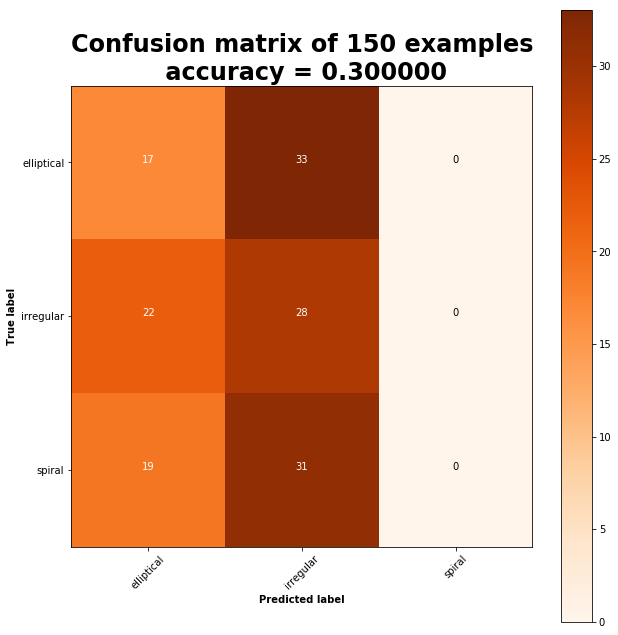

In [5]:
from config import CNNConfig
from models import CNN

cnn_config1 = CNNConfig()
cnn_config1.height=224
cnn_config1.width=224

print("Hyperparams:\n")

print(cnn_config1)

print("Keras model:\n")


cnn1 = CNN(cnn_config1)


print("\nTraining:\n")

stopper = EarlyStopping(monitor='acc', min_delta=0.0001, patience=3, verbose=1)

cnn1.fit_generator(train_generator, epochs=3,
          verbose=1, callbacks = [stopper])

pred = cnn1.predict_generator(test_generator)
pred= np.argmax(pred, 1)
plot_confusion_matrix(truth=test_generator.classes,
                      predictions=pred,
                      save=False,
                      path="tf_confusion_matrix.png",
                      classes=['elliptical', 'irregular','spiral'])

## Using the pre-trained model VGG19

Now we will use the ImageDataGenerator to preprocess all the images. We will set the images sizes to (224,224, 3) because this is the shape that the VGG19 is expecting.  

In [7]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory('/efigi_data/train',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory('/efigi_data/test',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Now let's download the model and remove its last layer.

In [8]:
base_model = VGG19()

574717952/574710816 [==============================] - 35s 0us/step


In [9]:
remove_top = 2
model = Model(base_model.input, base_model.layers[-remove_top].output)

We need to obtain the images from the generator to apply the function `preprocess_input` to them. We are preapring the images to be the input to this network.

In [10]:
train_data, train_labels = generator2array(train_generator)

In [11]:
test_data, test_labels = generator2array(test_generator)

Note that we will use the function `preprocess_input` to preprocess the data in a way that is suitable for the VGG19 model.

In [12]:
train_data = preprocess_input(train_data)
test_data = preprocess_input(test_data)

We now obtain the learned features from the VGG19. Depending of the computer this can be slow.

In [ ]:
train_embeddings = model.predict(train_data)

The train images now have been transformed in vectors.

In [ ]:
print(train_embeddings.shape)

Let's create a neural network to perform the prediction using the VGG19 vectors.

In [ ]:
from config import DFNConfig
from models import DFN

In [ ]:
dfn_config_tl = DFNConfig(input_dim=4096, architecture=[300,200,100,3])

print("Hyperparams:\n")
print(dfn_config_tl)

print("Keras model:\n")


dfn_tf = DFN(dfn_config_tl)
print(dfn_tf.summary())

In [ ]:
print("Training:\n")
dfn_tf.fit(train_embeddings,
           train_labels,
           batch_size=32,
           epochs=30,
           validation_split=0.2, 
           verbose=1)

To evaluate the model we need to apply the same transformation to the test data.

In [ ]:
test_embeddings = model.predict(test_data)

In [ ]:
print('\nAccuracy: {:.2f}'.format(dfn_tf.evaluate(test_embeddings,test_labels, verbose=1)[1]))

In [ ]:
train_generator.class_indices

In [ ]:
pred = dfn_tf.predict_classes(test_embeddings)
plot_confusion_matrix(truth=np.argmax(test_labels, 1),
                      predictions=pred,
                      save=False,
                      path="tf_confusion_matrix.png",
                      classes=['elliptical', 'irregular','spiral'])

We have trained one model using the vgg19 vectors, if you want you can download it to use here.

In [ ]:
if not os.path.exists("vgg19_4096_300_200_100_3.h5"):
    pro = subprocess.Popen(["bash", "download_efigi_model.sh"])
    pro.wait()

In [ ]:
dfn_tf.load_weights("vgg19_4096_300_200_100_3.h5")
pred = dfn_tf.predict_classes(test_embeddings)
plot_confusion_matrix(truth=np.argmax(test_labels, 1),
                      predictions=pred,
                      save=False,
                      path="tf_confusion_matrix.png",
                      classes=['elliptical', 'irregular','spiral'])

## Next steps: 
**See if you can use another trained model to get a better result than we have :)**
